Using TensorFlow backend.


Found 100 images belonging to 4 classes.
Sample of input images
label of [0. 0. 1. 0.]
Shape of (1, 150, 150, 3)
label of [0. 0. 1. 0.]
Shape of (1, 150, 150, 3)


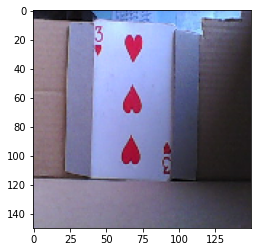

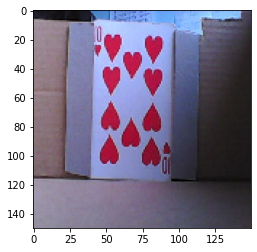

In [1]:
# d6625
# Generate a model that classifies card suits, from the images created
# Uses images in suits/train and suits/test (but test is not added yet)
# Heavily "inspired" by catsvdogs model from keras
# Ripped from value-agent.ipynb

import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

base_dir = '/Users/James/PycharmProjects/jerry/cards'
suit_dir = os.path.join(base_dir, 'suits')
train_dir = os.path.join(suit_dir, 'train')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 1

generator = datagen.flow_from_directory(train_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        color_mode='rgb',
                                        class_mode='categorical')

length = 104  # how far to cycle to see every image
i = 5
print('Sample of input images')
for inputs_batch, labels_batch in generator:
    plt.imshow(inputs_batch.reshape(150,150,3))
    #plt.matshow(inputs_batch[0].reshape(150,150))
    plt.show()
    print('label of', labels_batch[0])
    print('Shape of', inputs_batch.shape)
    if i > 5:
        break
    i += 1

In [2]:
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop

# Probably too complex for this situiation, but I don't care
model = Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))  # Make the view larger; find bigger patterns
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())  # Dimension reduce
model.add(layers.Dropout(0.5))  # Get rid of conspiracies
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # 4 suits

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [3]:
from time import time
start = time()
history = model.fit_generator(generator,
                              steps_per_epoch=4,  # 32 * 4 = 128 from 104 samples
                              epochs=200,
                              verbose=0)  # total of 128*100=12800 samples used
print('Took',(time()-start).__round__(4),'seconds to train the network')

Took 35.517 seconds to train the network


In [11]:
# save the model
print('Saving model...')
model.save('suit-v1.h5')
print('Saved.')

Saving model...
Saved.


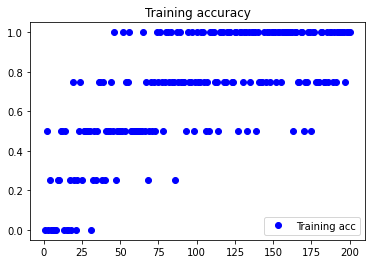

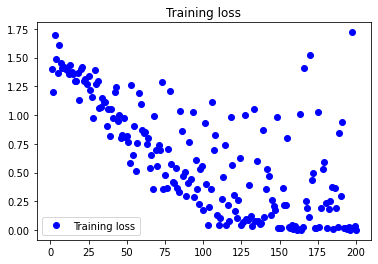

In [4]:
# Visualise the training data
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']


epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()  # Combines the two graphs

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

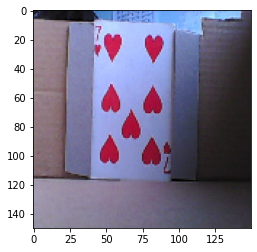

2
2
2


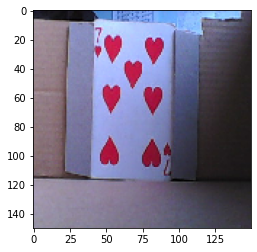

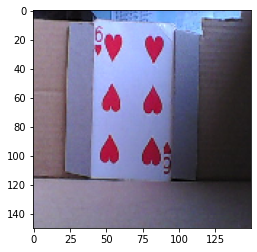

In [10]:
# Test on custom image
from keras.preprocessing import image


dir = os.path.join(train_dir, 'heart')
fnames = [os.path.join(dir, fname) for fname in os.listdir(dir)]

for img_path in fnames[:3]:  # only first 3 plz
    img = image.load_img(img_path, target_size=(150,150),
                         color_mode='rgb')

    x = image.img_to_array(img)
    x = x.astype('float32')/255
    x = x.reshape((1,) + x.shape)  # Convert from (150,150,3) to (1,150,150,3)

    plt.imshow(img)
    plt.show()
    pred = np.argmax(model.predict(x, verbose=0)[0])
    print(pred)
    
    #print('Pred of', pred.__round__(5), '{' +str(pred.__round__(0)) + '}')
    #print('Meaning the model is ' + str(pred.__round__(2)*100) + '% of it being 1')
    




